# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [230]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [231]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [232]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: DummyClassifier с параметром startegy='uniform' выбирает рандомно случайные классы (с равными вероятностями для всех классов), следовательно, на каждом объекте вероятность его принадлежности к 0-классу = 0.5 и вероятность его принадлежности к 1-классу = 0.5.
Метод predict_proba возвращает двумерный массив с вероятностями принадлежности каждого объекта к 0-классу и к 1-классу (random_classifier.predict_proba(X_test)[ : , 1] - выдает массив, в котором будут только вероятности принадлежности каждого объекта к 1-классу).

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [233]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


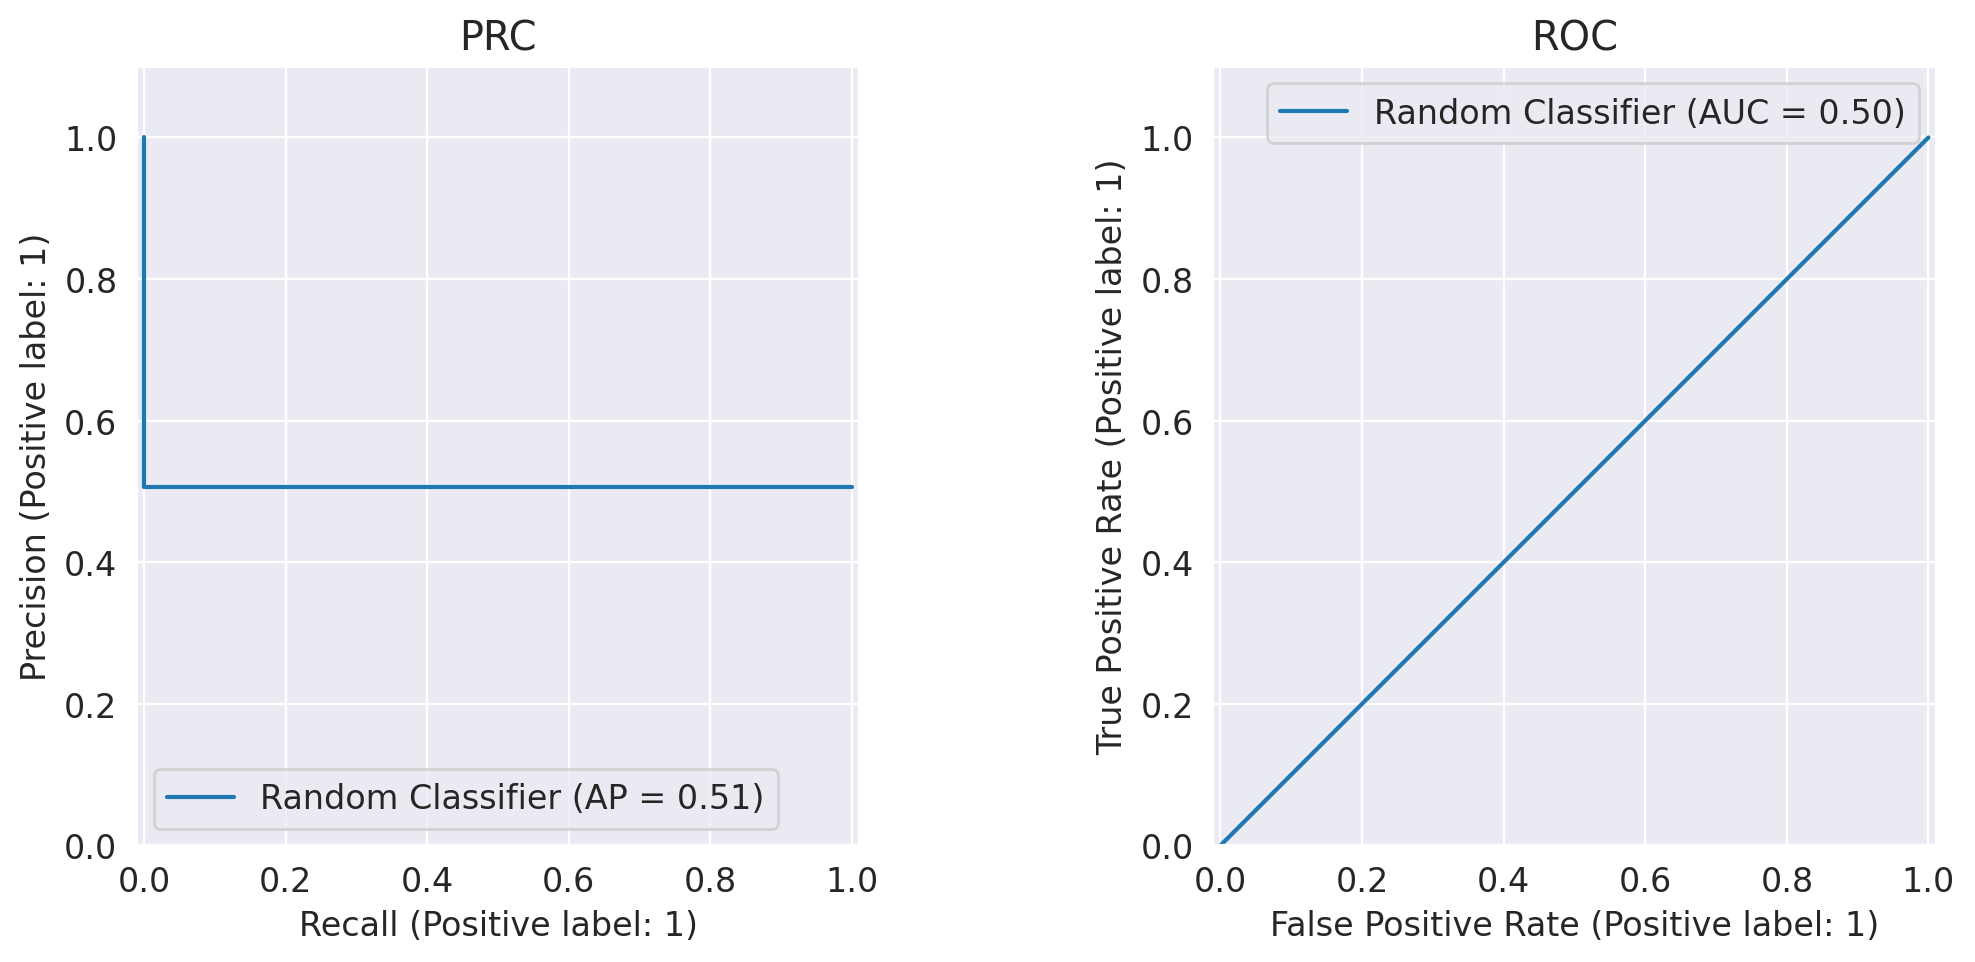

In [234]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [235]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [236]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score

# your code here
model = LinearSVC()
params = np.logspace(-3, 3, 50)
#params = {'C': [0.01, 0.1, 1, 10, 100]}
searcher = GridSearchCV(model, [{'C': params}], scoring='average_precision', cv=10)
searcher.fit(X_train, y_train)

best_C_svm = searcher.best_params_['C']
print("Best C =", best_C_svm)
print("Best AUC-PR on train =", searcher.best_score_)

Best C = 0.06866488450043001
Best AUC-PR on train = 0.8246468696236443


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

Regularized SVM Classifier metrics
AUC-PR: 0.7141
AUC-ROC: 0.7717


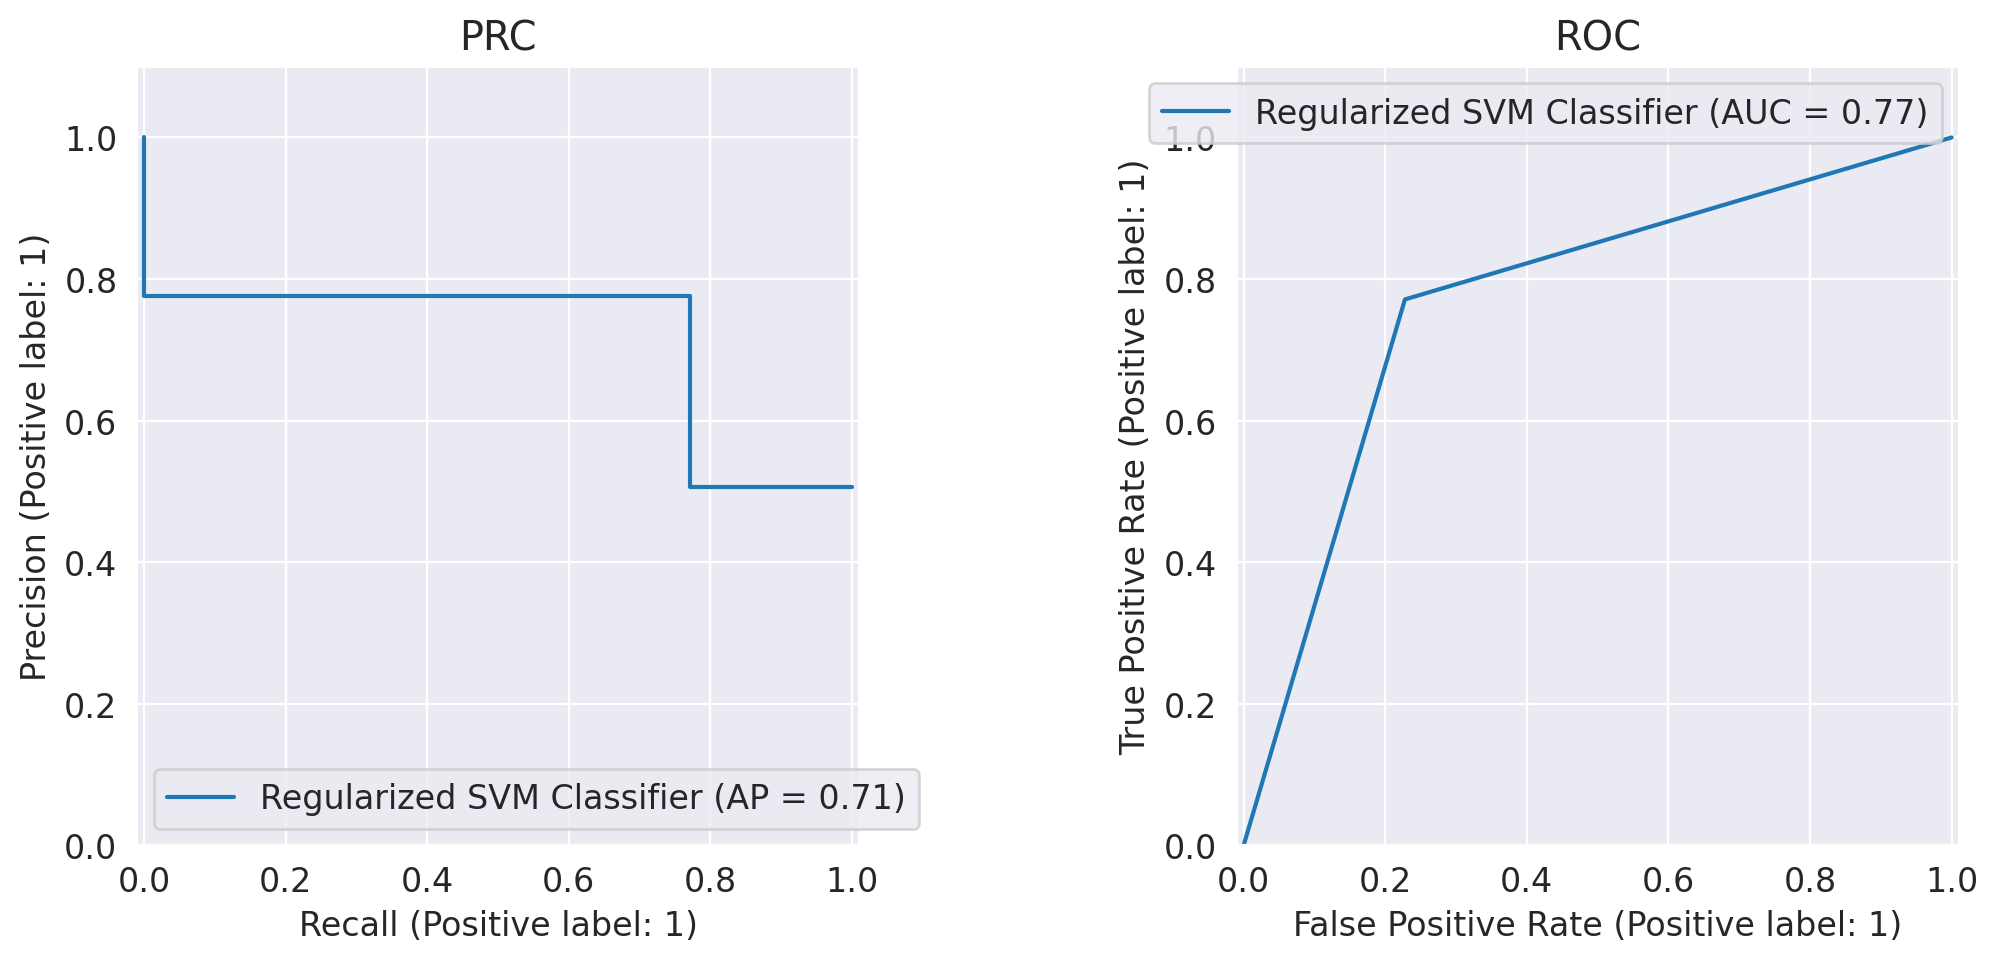

In [237]:
# your code here
svm = LinearSVC(C = best_C_svm)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
depict_pr_roc(y_test, y_pred_svm, 'Regularized SVM Classifier')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

1) Рассмотрим PRC: при увеличении порога вероятности, выше которого классификатор относит объект к положительному классу precision увеличивается, поскольку модель становится более "избирательной", а recall наоборот снижается, так как меньше объектов предсказываются как положительные.

2) Рассмотрим ROC: с ростом порога, уменьшается количество ложно положительных ложных срабатываний (FPR), но также снижается доля true положительных объектов (TPR).
На графике ROC можно видеть, что кривая поднимается вверх, пока модель правильно разделяет положительные и отрицательные классы.

Монотонность PRC: не обязательно монотонна, что видно на графике. Это связано с тем, что precision и recall могут изменяться в разных направлениях в зависимости от предсказанных вероятностей.

Монот ROC: ROC-кривая всегда монотонна, так как она построена на основе FPR и TPR, которые растут или остаются неизменными с уменьшением порога классификации.




Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [238]:
# your code here
df_metrics.loc['Regularized SVM Classifier'] = [
      average_precision_score(y_test, y_pred_svm),
      roc_auc_score(y_test, y_pred_svm),
      best_C_svm,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000000
Regularized SVM Classifier,0.714057,0.771671,0.068665


Видно, что метрики регуляризованного классификатора SVM улучшились по сравнению с случайным классификатором.

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [239]:
from sklearn.linear_model import LogisticRegression

# your code here
model = LogisticRegression()
params = np.logspace(-5, 2, 50)
searcher = GridSearchCV(model, [{'C': params}], scoring='average_precision', cv=10)
searcher.fit(X_train, y_train)

best_C_logreg = searcher.best_params_['C']
print("Best C = ",  best_C_logreg)
print("Лучший AUC-PR на обучении:", searcher.best_score_)

Best C =  0.0003727593720314938
Лучший AUC-PR на обучении: 0.8298554093616348


Regularized LogReg Classifier metrics
AUC-PR: 0.7084
AUC-ROC: 0.7654


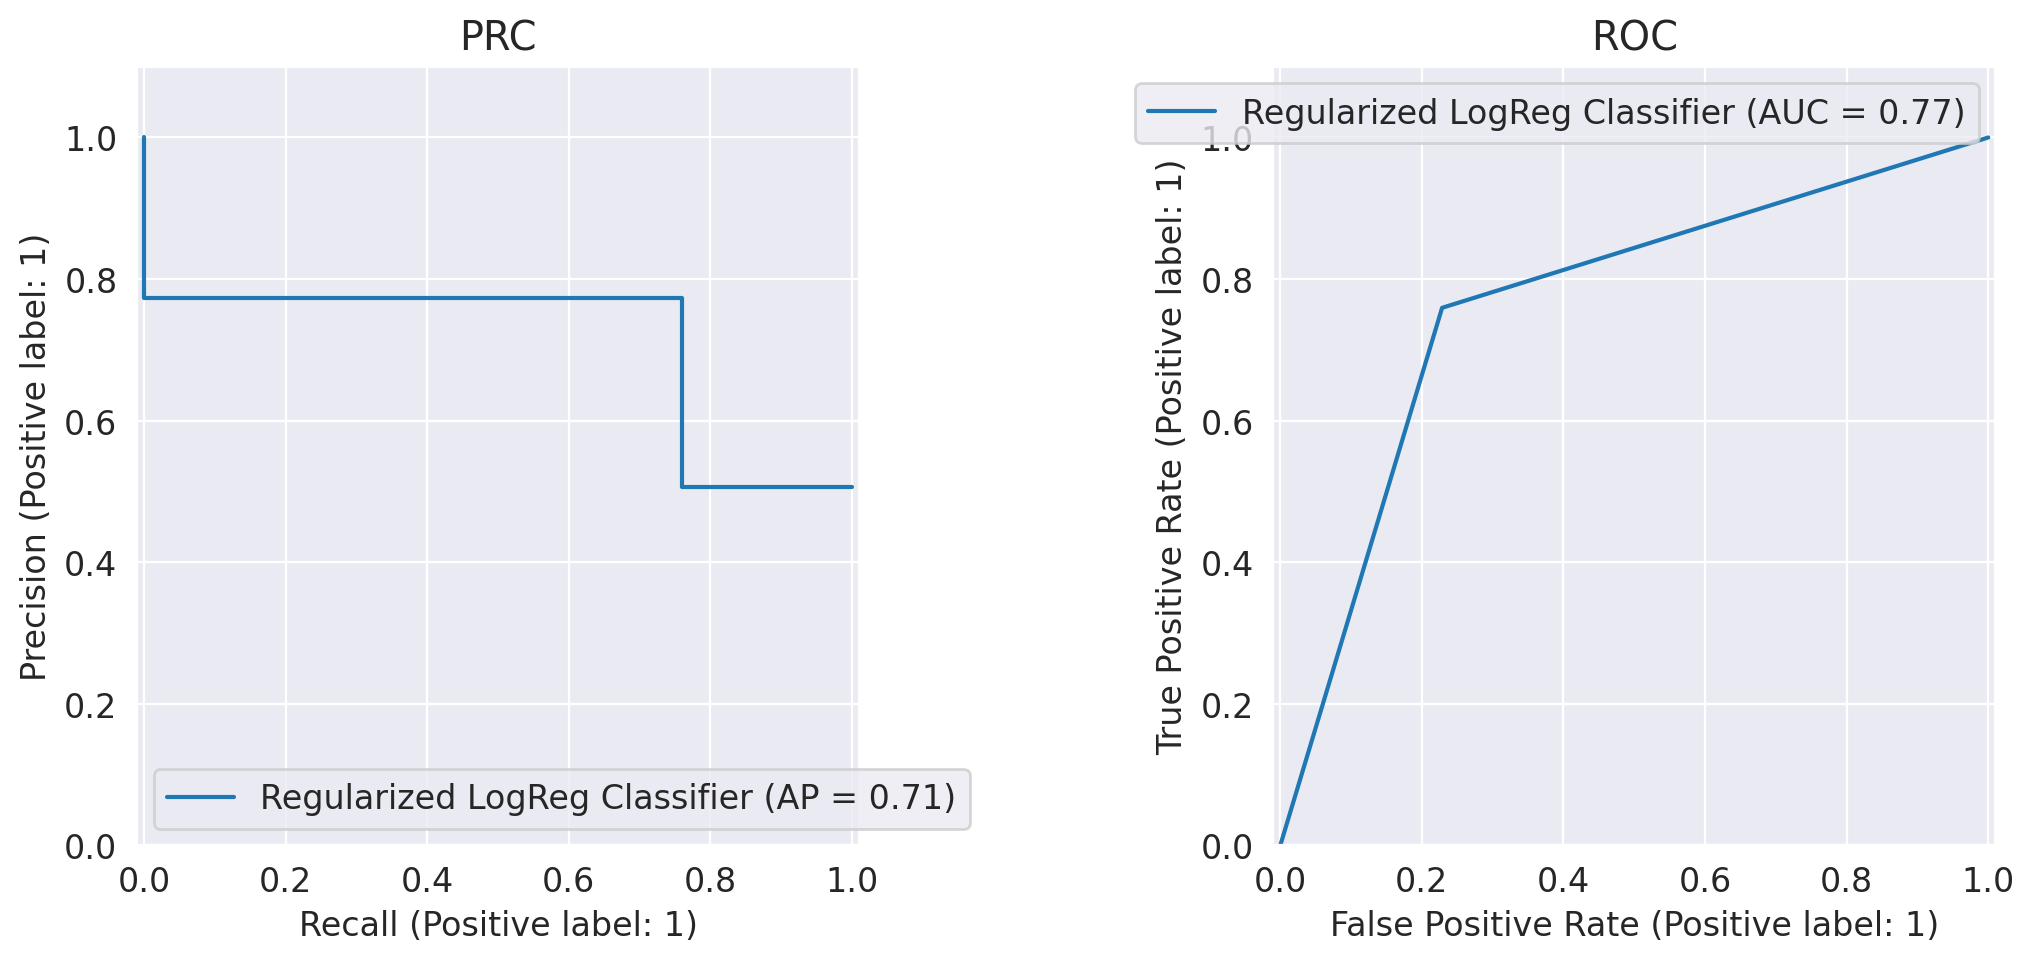

In [240]:
logreg = LogisticRegression(C = best_C_logreg)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
depict_pr_roc(y_test, y_pred_logreg, 'Regularized LogReg Classifier')

In [241]:
df_metrics.loc['Regularized LogReg Classifier'] = [
      average_precision_score(y_test, y_pred_logreg),
      roc_auc_score(y_test, y_pred_logreg),
      best_C_logreg,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000000
Regularized SVM Classifier,0.714057,0.771671,0.068665
Regularized LogReg Classifier,0.708401,0.765401,0.000373


Видно, что метрики регуляризованного классификатора LogReg улучшились по сравнению с случайным классификатором.

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
Regularized SVM Classifier metrics
AUC-PR: 0.7141
AUC-ROC: 0.7717
Regularized LogReg Classifier metrics
AUC-PR: 0.7084
AUC-ROC: 0.7654


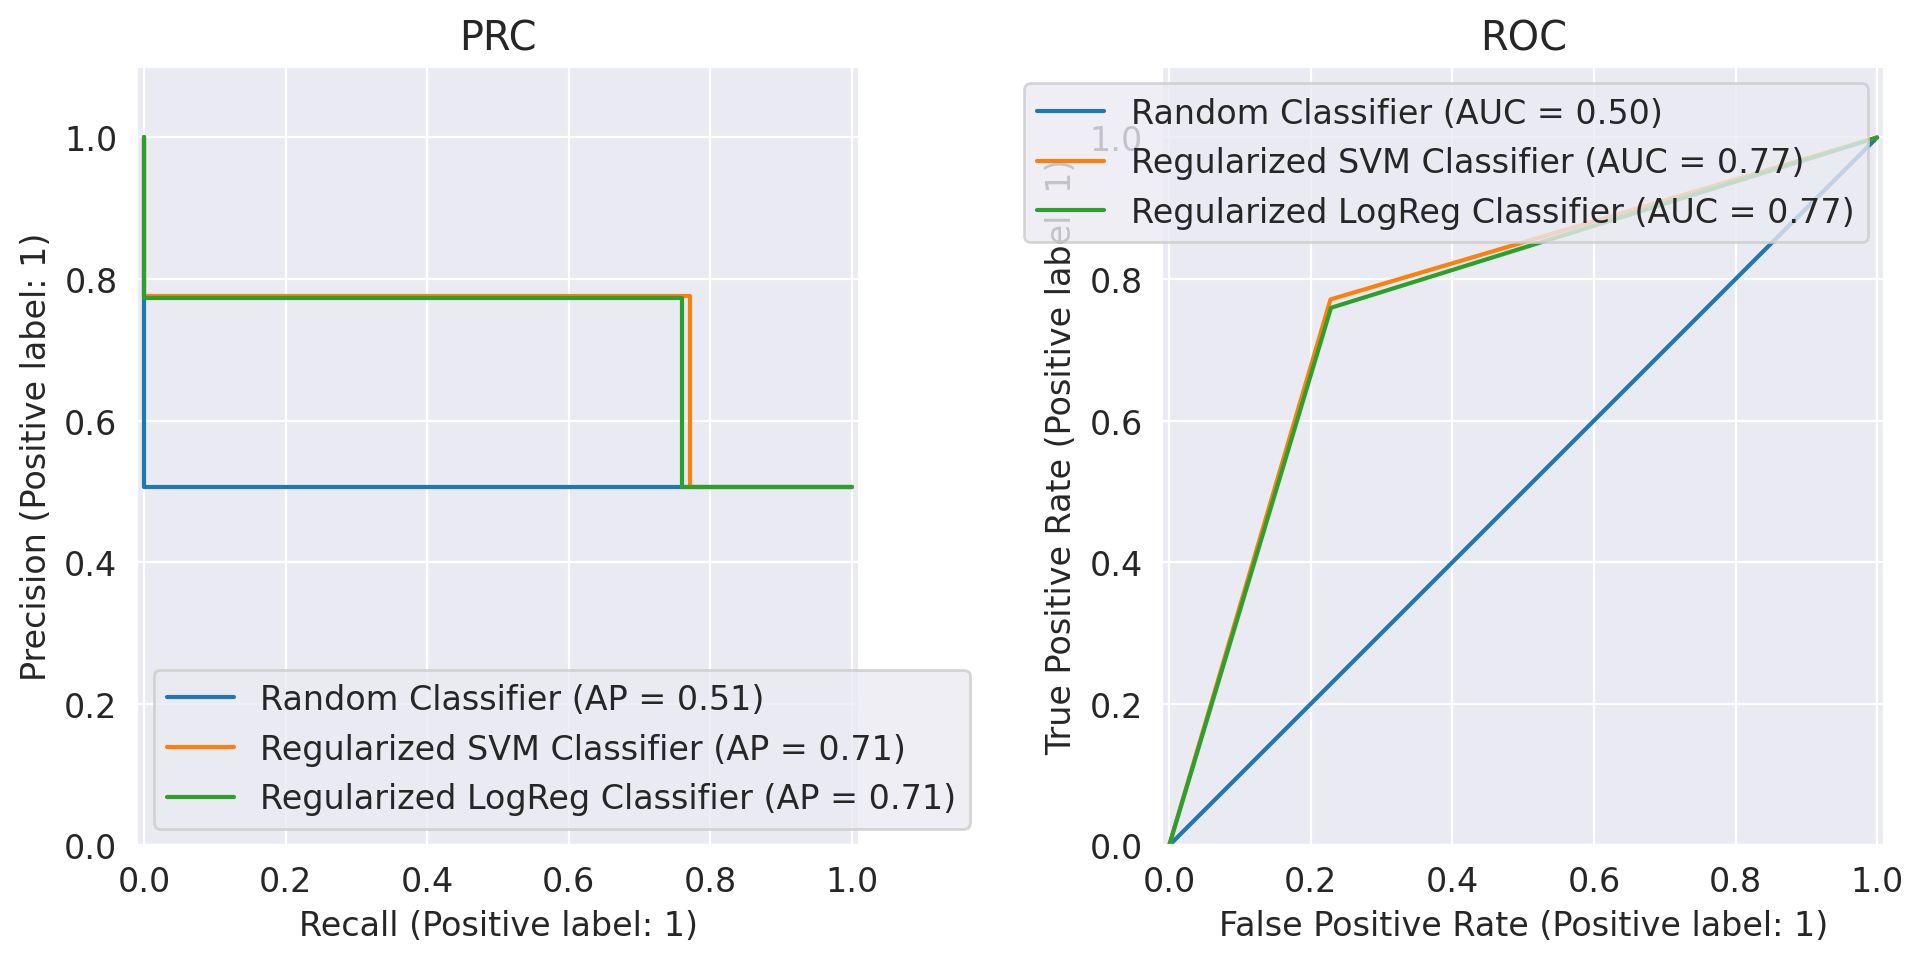

In [242]:
# your code here
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
depict_pr_roc(y_test, y_random, 'Random Classifier', ax)
depict_pr_roc(y_test, y_pred_svm, 'Regularized SVM Classifier', ax)
depict_pr_roc(y_test, y_pred_logreg, 'Regularized LogReg Classifier', ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** метрики логрега немного хуже, чем метрики SVM, но вообще они практически не отличаются. Это можно объяснить тем, что, возможно, эти оба классификатора хорошо работают благодаря хорошо подобранным параметрам регуляризации. Также, может быть, это происходит благодаря тому, что наша выборка более менее линейно разделима.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [81]:
# your code here
from sklearn.svm import SVC
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42
)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = SVC(kernel='linear')
model.fit(X, y)

SVC(kernel='linear')

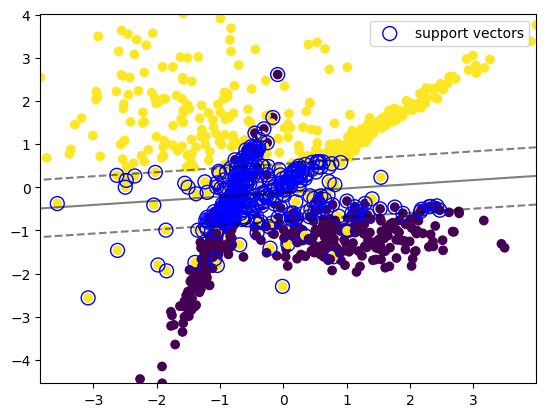

In [82]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy) # выдает расстояние от точки до разделяющей гиперплоскости
    Z = Z.reshape(XX.shape)


    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(
        # your code here
        X[:, 0],
        X[:, 1],
        c = y

    )

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            # your code here
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** как "опорные" выделяются те объекты выборки, которые находятся на границе классов или довольно-таки близко к ней (они определяют положение гиперплоскости)

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [84]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

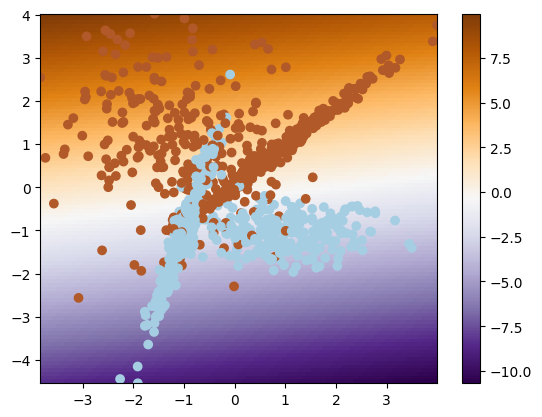

In [85]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.decision_function(xy)
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        # your code here
        X[:, 0],
        X[:, 1],
        c = y,
        cmap=plt.cm.Paired
    )

    plt.colorbar(image)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** эта область визуализирована белой полосой (значение 0.0 или близкое к нему). Пусть model_decision выдает число z (оно отображено на графике), следовательно, там, где модель не уверена, z = 0. Логистическая регрессия использует сигмоиду, чтобы преобразовывать z в вероятность принадлежности объекта к положительному классу $𝑝(𝑦=+1|𝑥)$, использует сигмоиду $σ(z)=\frac{1}{1+exp(-z)}$, а $σ(0)=0.5$.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [86]:
def plot_calibration_curve(y_test, preds, name='default'):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    #plt.figure(figsize=(6,6))
    if name == 'LR':
      plt.plot(bin_middle_points, bin_real_ratios, label=name, linestyle='-', color='red')
    elif name == 'SVC':
      plt.plot(bin_middle_points, bin_real_ratios, label=name, linestyle='-', color='green')
    else:
      plt.plot(bin_middle_points, bin_real_ratios, label=name, linestyle='-')
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration curves')
    plt.legend()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

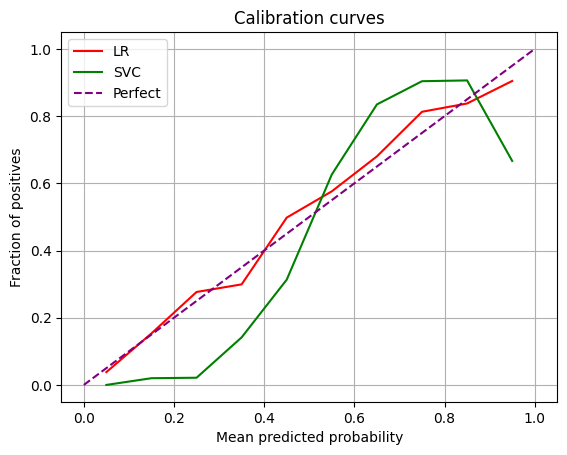

<Figure size 600x600 with 0 Axes>

In [87]:
# your code here
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict_proba(X_test)[:, 1]

svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.decision_function(X_test)
y_pred_svm = (y_pred_svm - y_pred_svm.min()) / (y_pred_svm.max() - y_pred_svm.min()) # масштабируем через min-max, чтобы перевести значения в диапазон от 0 до 1

plot_calibration_curve(y_test, y_pred_lr, 'LR')

plot_calibration_curve(y_test, y_pred_svm, name='SVC')

plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='purple')
plt.legend()
plt.grid()
plt.figure(figsize=(6,6))
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** для логистической регрессии кривая откалибрована хорошо, так как приближена к калибровочной кривой для идеально откалиброванной модели (диагональ). Этого нельзя сказать о кривой для SVM (она вообще не приближена к диагонали).

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [88]:
# your code here
from sklearn.metrics import log_loss
print('LogLoss for LR =', log_loss(y_test, y_pred_lr))
print('LogLoss for SVC =', log_loss(y_test, y_pred_svm))

from sklearn.metrics import brier_score_loss
print('BrierScore for LR =', brier_score_loss(y_test, y_pred_lr))
print('BrierScore for SVC =', brier_score_loss(y_test, y_pred_svm))

LogLoss for LR = 0.4858556295167715
LogLoss for SVC = 0.5545841217764482
BrierScore for LR = 0.15858348672613165
BrierScore for SVC = 0.184488164702083


LogLoss и BrierScore тоже показывают, что SVM хуже справляется с предсказаниями вероятностей, чем LogisticRegression (это неудивительно, ведь у SVM целью является корректное предсказание класса объекта, а LogisticRegression стремится корректно оценивать вероятности классов на каждом объекте - объясняется разными функциями потерь: hinge loss у SVM и логистическая функция потерь у LogisticRegression).

Изучите распределение ответов классификаторов при помощи гистограмм

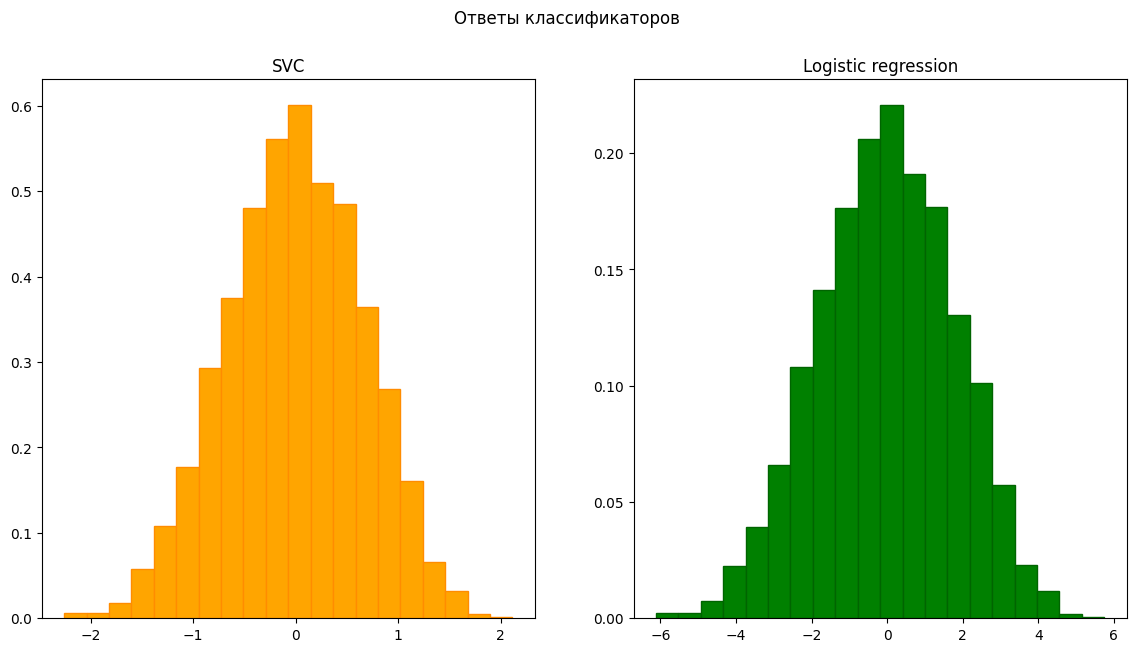

In [89]:
# your code here
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svm.decision_function(X_test), bins=20, color='orange', edgecolor='darkorange', density='True')
axs[1].hist(logreg.decision_function(X_test), bins=20, color='green', edgecolor='darkgreen', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Ответы классификаторов')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Диапазон распределения ответов SVM меньше диапазона распределения ответов логистической регрессии. Это можно объяснить тем, что логистическая реграссия стремится корректно оценивать вероятности классов на каждом объекте (это достигается при подстановке ответов классификатора в сигмоиду и последующем использовании логистической функции потерь). Целью SVM, напротив, является лишь корректное предсказание класса объекта, поэтому он "забивает" на вероятности (объясняется используемой функцией потерь hinge loss), а, следовательно, диапазон его ответов меньше.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

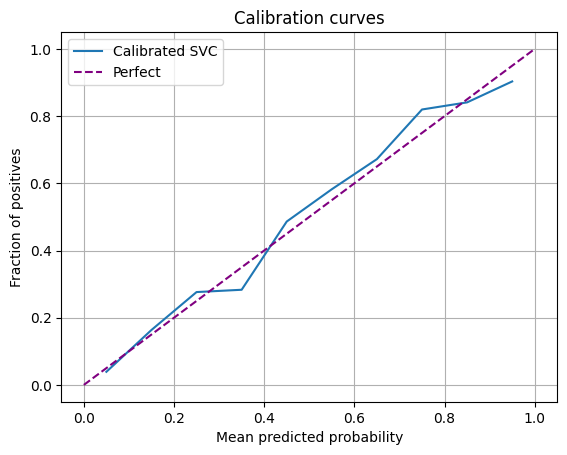

<Figure size 600x600 with 0 Axes>

In [90]:
# your code here
# используем калибровку Платта
from sklearn.calibration import CalibratedClassifierCV
sigmoid_svm = CalibratedClassifierCV(svm, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_svm_pred = sigmoid_svm.predict_proba(X_test)[:, 1]
y_pred_svm_cal = sigmoid_svm.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, y_pred_svm_cal, name='Calibrated SVC')

plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='purple')

plt.legend()

plt.figure(figsize=(6,6))

plt.show()

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** да, калибровочная кривая и качество калибровки значительно улучшились, так как она стала приближена к калибровочной кривой для идеально откалиброванной модели (диагональ).

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [91]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [92]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [93]:
!wget  -O 'bike_buyers.csv' -q 'https://www.dropbox.com/scl/fi/bgkx1vrurosdr1835m0ec/bike_buyers.csv?rlkey=b97m14hvxje7zs0amh2aaesv1&st=md0c9ew0&dl=0'

In [243]:
data = pd.read_csv('bike_buyers.csv')

In [244]:
data.loc[data['Purchased Bike'] == 'Yes', 'Purchased Bike'] = 1
data.loc[data['Purchased Bike'] == 'No', 'Purchased Bike'] = 0

In [245]:
data['Purchased Bike'] = data['Purchased Bike'].astype(int)

In [246]:
# Прочитаем датасет
# your code here

# Заменим пропуски категориальных переменных
# your code here
numerical = ['Income', 'Children', 'Cars', 'Age']
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
data[categorical] = data[categorical].fillna('undefined')

# Отделим X и y
# your code here
X = data.copy()
y = X['Purchased Bike']
X = X.drop(columns=['Purchased Bike'])

# Разделим на категориальные признаки и числовые
# your code here
X_numerical = X[numerical]
X_categorical = X[categorical]

В начале поработаем только с категориальными признаками

In [247]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [128]:
# your code here
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
import time
time_start = time.time()

column_transformer = ColumnTransformer([
    ("ordinal", OrdinalEncoder(), categorical)
    ], remainder='passthrough'
    )

X_train_trans = column_transformer.fit_transform(X_train)
X_test_trans = column_transformer.transform(X_test)

model = LogisticRegression()
model.fit(X_train_trans, y_train)
time_end = time.time() - time_start
print('Время, потребовавшееся на обучение модели, с учетом кодирования признаков:', time_end)
y_pred_proba = model.predict_proba(X_test_trans)[:, 1]

print('AUC-PR на тесте:', average_precision_score(y_test, y_pred_proba))

Время, потребовавшееся на обучение модели, с учетом кодирования признаков: 0.023522138595581055
AUC-PR на тесте: 0.5886533539773633


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [129]:
# your code here
from sklearn.preprocessing import OneHotEncoder
time_start = time.time()

column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical)
    ], remainder='passthrough'
    )

X_train_trans1 = column_transformer.fit_transform(X_train)
X_test_trans1 = column_transformer.transform(X_test)

model = LogisticRegression()
model.fit(X_train_trans1, y_train)
time_end = time.time() - time_start
print('Время, потребовавшееся на обучение модели, с учетом кодирования признаков:', time_end)
y_pred_proba = model.predict_proba(X_test_trans1)[:, 1]

print('AUC-PR на тесте:', average_precision_score(y_test, y_pred_proba))

Время, потребовавшееся на обучение модели, с учетом кодирования признаков: 0.03799152374267578
AUC-PR на тесте: 0.6662544177340515


Видно, что по метрике AUC-PR качество модели улучшилось (в сравнении с тем, что было до кодирования, то есть при использовании OrdinalEncoder).

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [130]:
# your code here
X_train_mte = X_train.copy()
X_test_mte = X_test.copy()

time_start = time.time()

for col in list(X_train_mte.columns):
  for val in list(X_train_mte[col].unique()):
    ser = [X_train_mte[col] == val]
    mean_target = y_train[np.array(ser).flatten()].mean()
    X_train_mte.loc[X_train_mte[col] == val, col] = mean_target
    X_test_mte.loc[X_test_mte[col] == val, col] = mean_target

model = LogisticRegression()
model.fit(X_train_mte, y_train)

time_end = time.time() - time_start
print('Время, потребовавшееся на обучение модели, с учетом кодирования признаков:', time_end)

y_pred_proba = model.predict_proba(X_test_mte)[:, 1]
print('AUC-PR на тесте:', average_precision_score(y_test, y_pred_proba))

Время, потребовавшееся на обучение модели, с учетом кодирования признаков: 0.08473014831542969
AUC-PR на тесте: 0.6575110261581697


Время на Mean-target Encoding увеличилось по сравнению с Ordinal Encoding и OHE.

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

Чтобы решить данное задание, воспользовался chat gpt, пришлось делать несколько промптов:

1) просто задание, он выдал код с принимаемым параметром "сглаживание"

2) попросил переписать без него "перепиши этот код без сглаживания", выдал код с принимаемым параметром target_column

3) попросил переписать бкз него "перепиши код так, чтобы класс принимал только categorical_features без target_column"

4) выдал нужный код, но с подсчетом global_mean зачем-то (возможно, остался от сглаживания), поэтому я сам убрал этот параметр из init и transform, где он хотел заменять NaN на глобальное среднее (на случай новых категорий)

In [258]:
# your code here
from sklearn.base import BaseEstimator, TransformerMixin
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        """
        Parameters:
        - categorical_features: list of str, список категориальных признаков для кодирования.
        """
        self.categorical_features = categorical_features
        self.encoding_dict = {}

    def fit(self, X, y):
        X = X.copy()
        X['target'] = y


        for feature in self.categorical_features:
            # Вычисляем среднее значение целевой переменной для каждой категории
            stats = X.groupby(feature)['target'].mean()
            self.encoding_dict[feature] = stats

        return self

    def transform(self, X):
        X_transformed = X.copy()

        for feature in self.categorical_features:
            if feature in self.encoding_dict:
                encoding = self.encoding_dict[feature]
                X_transformed[feature] = X_transformed[feature].map(encoding)

        return X_transformed

    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

In [259]:
X_train_mtec = X_train.copy()
X_test_mtec = X_test.copy()

encoder = MeanTargetEncoder(categorical)

X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

model = LogisticRegression()
model.fit(X_train_encoded, y_train)

y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]
print('AUC-PR на тесте:', average_precision_score(y_test, y_pred_proba))

AUC-PR на тесте: 0.6575110261581697


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [142]:
# your code here
X_train_mte_n = X_train.copy()
X_test_mte_n = X_test.copy()

noise_small = 0.01 # для больших категорий (много объектов, следовательно, нет большой потребности в шуме)
noise_big = 0.1 # для маленьких категорий (мало объектов, следовательно, высокая вероятность target leak-а, и чтобы его избежать добавляем большой)

for col in list(X_train_mte_n.columns):
  for val in list(X_train_mte_n[col].unique()):
    ser = [X_train_mte_n[col] == val]
    if X_train_mte_n[X_train_mte_n[col] == val].shape[0] <= 10:
      mean_target = y_train[np.array(ser).flatten()].mean() + np.random.uniform(-noise_big, noise_big)
    else:
      mean_target = y_train[np.array(ser).flatten()].mean() + np.random.uniform(-noise_small, noise_small)
    X_train_mte_n.loc[X_train_mte_n[col] == val, col] = mean_target
    X_test_mte_n.loc[X_test_mte_n[col] == val, col] = mean_target

model = LogisticRegression()
model.fit(X_train_mte_n, y_train)

y_pred_proba = model.predict_proba(X_test_mte_n)[:, 1]

print('AUC-PR на тесте:', average_precision_score(y_test, y_pred_proba))

AUC-PR на тесте: 0.6749280126510545


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** да, помогло (AUC-PR на тесте увеличился: был 0.6575110261581697, стал 0.6749280126510545). Это можно объяснить тем, что внесением шума мы постарались избежать target leak-а, из-за которого модель могла переобучаться и хуже работать на тестовой выборке.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [104]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [143]:
# your code here
X_train_glad = X_train.copy()
X_test_glad = X_test.copy()
params = np.logspace(-1, 2, 50)
global_mean = y_train.mean()
best_C = params[0]
best_auc_pr = 0

for C in params:
  for col in list(X_train_glad.columns):
    for val in list(X_train_glad[col].unique()):
      ser = [X_train_glad[col] == val]
      mean_target = (y_train[np.array(ser).flatten()].sum() + C * global_mean) / (y_train[np.array(ser).flatten()].shape[0] + C)
      X_train_glad.loc[X_train_glad[col] == val, col] = mean_target
      X_test_glad.loc[X_test_glad[col] == val, col] = mean_target
  model = LogisticRegression()
  model.fit(X_train_glad, y_train)

  y_pred_proba = model.predict_proba(X_test_glad)[:, 1]
  if average_precision_score(y_test, y_pred_proba) > best_auc_pr:
    best_C = C
    best_auc_pr = average_precision_score(y_test, y_pred_proba)

print('Best C:', best_C)
print('AUC-PR на тесте:', best_auc_pr)

Best C: 5.963623316594643
AUC-PR на тесте: 0.6722589534570758


AUC-PR лучше, чем при OHE (0.6662544177340515).

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



Наилучшее качество (самый высокий AUC-PR) показал Mean-target c шумом, поэтому будем использовать этот способ.

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
mpl.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

Populating the interactive namespace from numpy and matplotlib


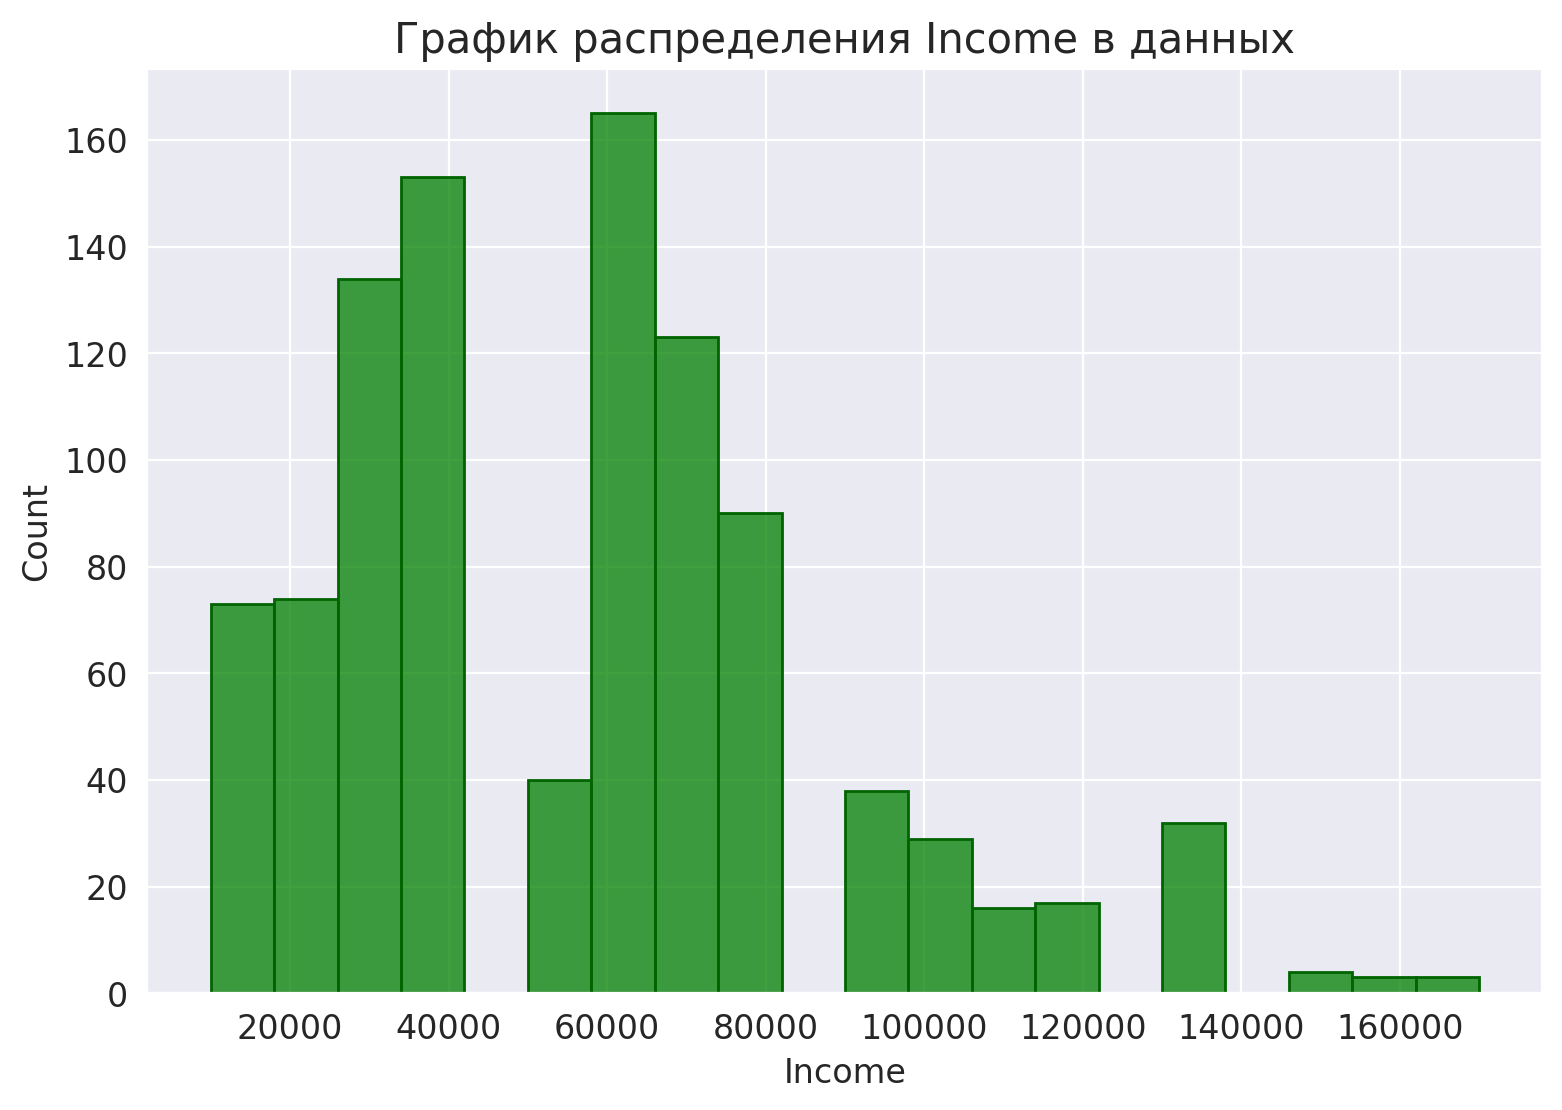

In [107]:
# your code here
X = data.copy()
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('График распределения Income в данных', fontsize=15)
sns.histplot(X.Income,
             ax=ax,

             color='green',
             edgecolor='darkgreen')

plt.show()

По распределению дохода видно, что он кратен 10000, следовательно, лучше будет заполнить пропуски медианой, чтобы не получать странных для выборки значений.

Что касается, признаков Children, Cars и Age, их тоже стоит заполнять медианой, поскольку странным будет значение, например, 2.5 машины или 3.2 ребенка.

In [108]:
for col in numerical:
  X[col] = X[col].fillna(X[col].median())

In [109]:
mask = X['Income'] < np.quantile(X['Income'], 0.99)

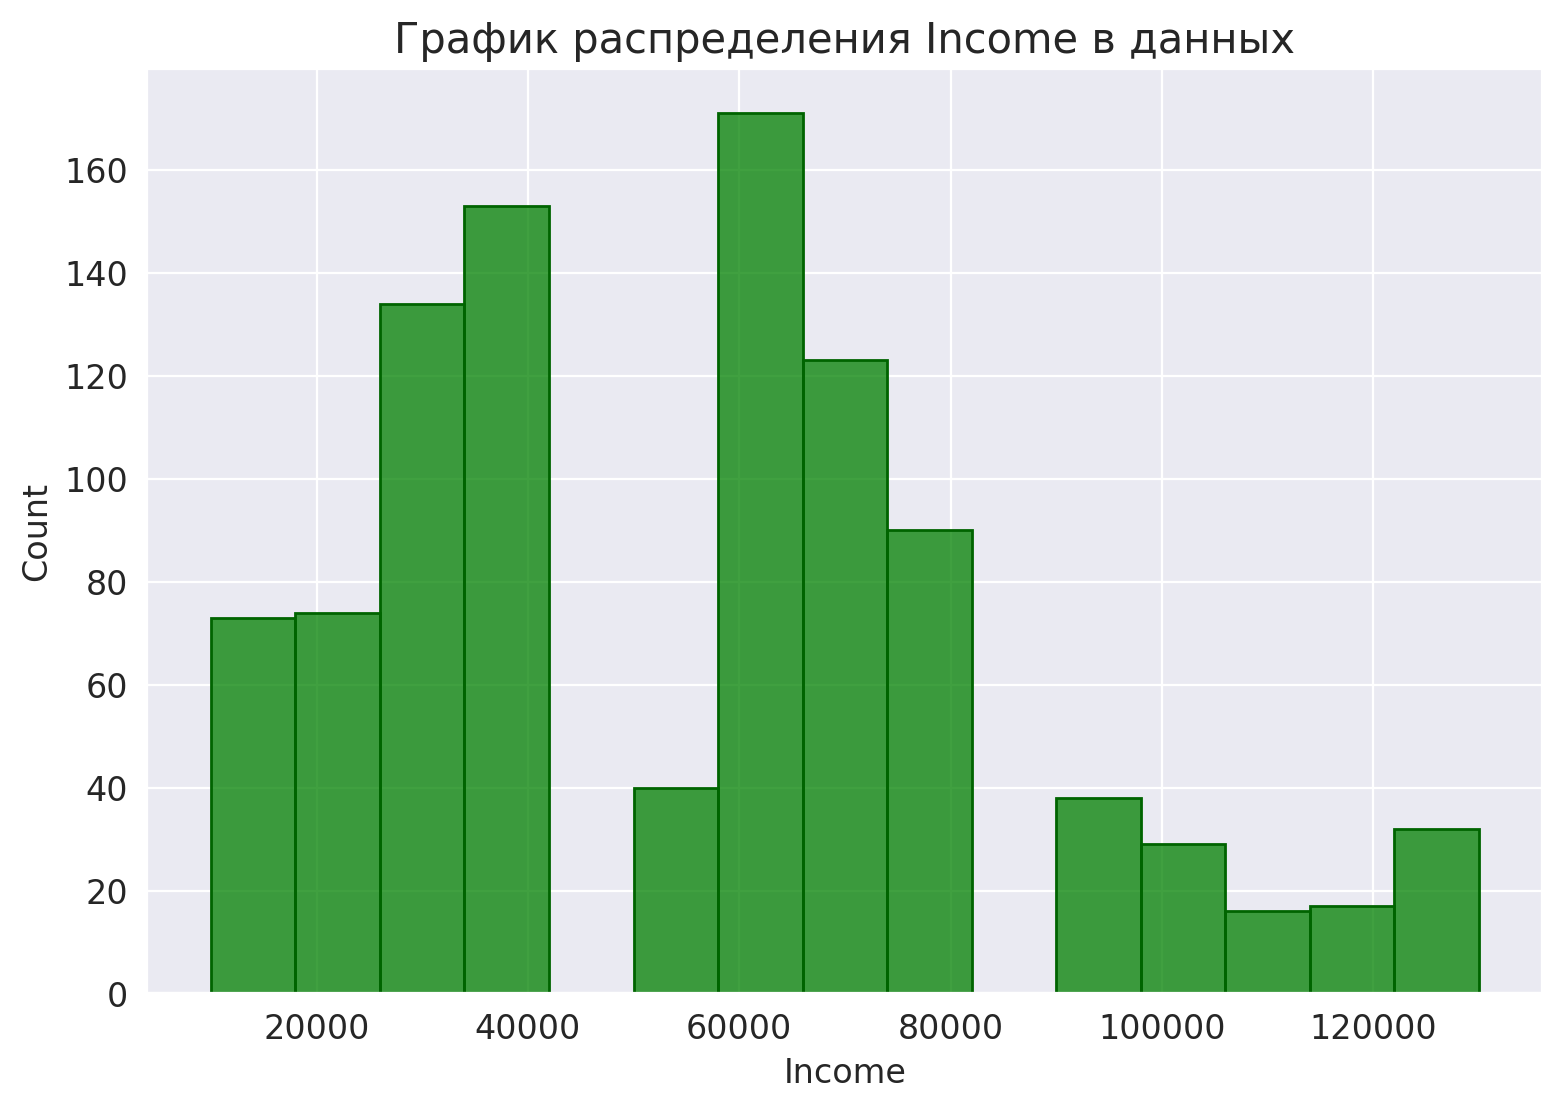

In [110]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('График распределения Income в данных', fontsize=15)
sns.histplot(X[mask].Income,
             ax=ax,

             color='green',
             edgecolor='darkgreen')

plt.show()

Избавимся от выбросов в Income (удалим 1% наибольших по Income).

In [111]:
X = X[mask]

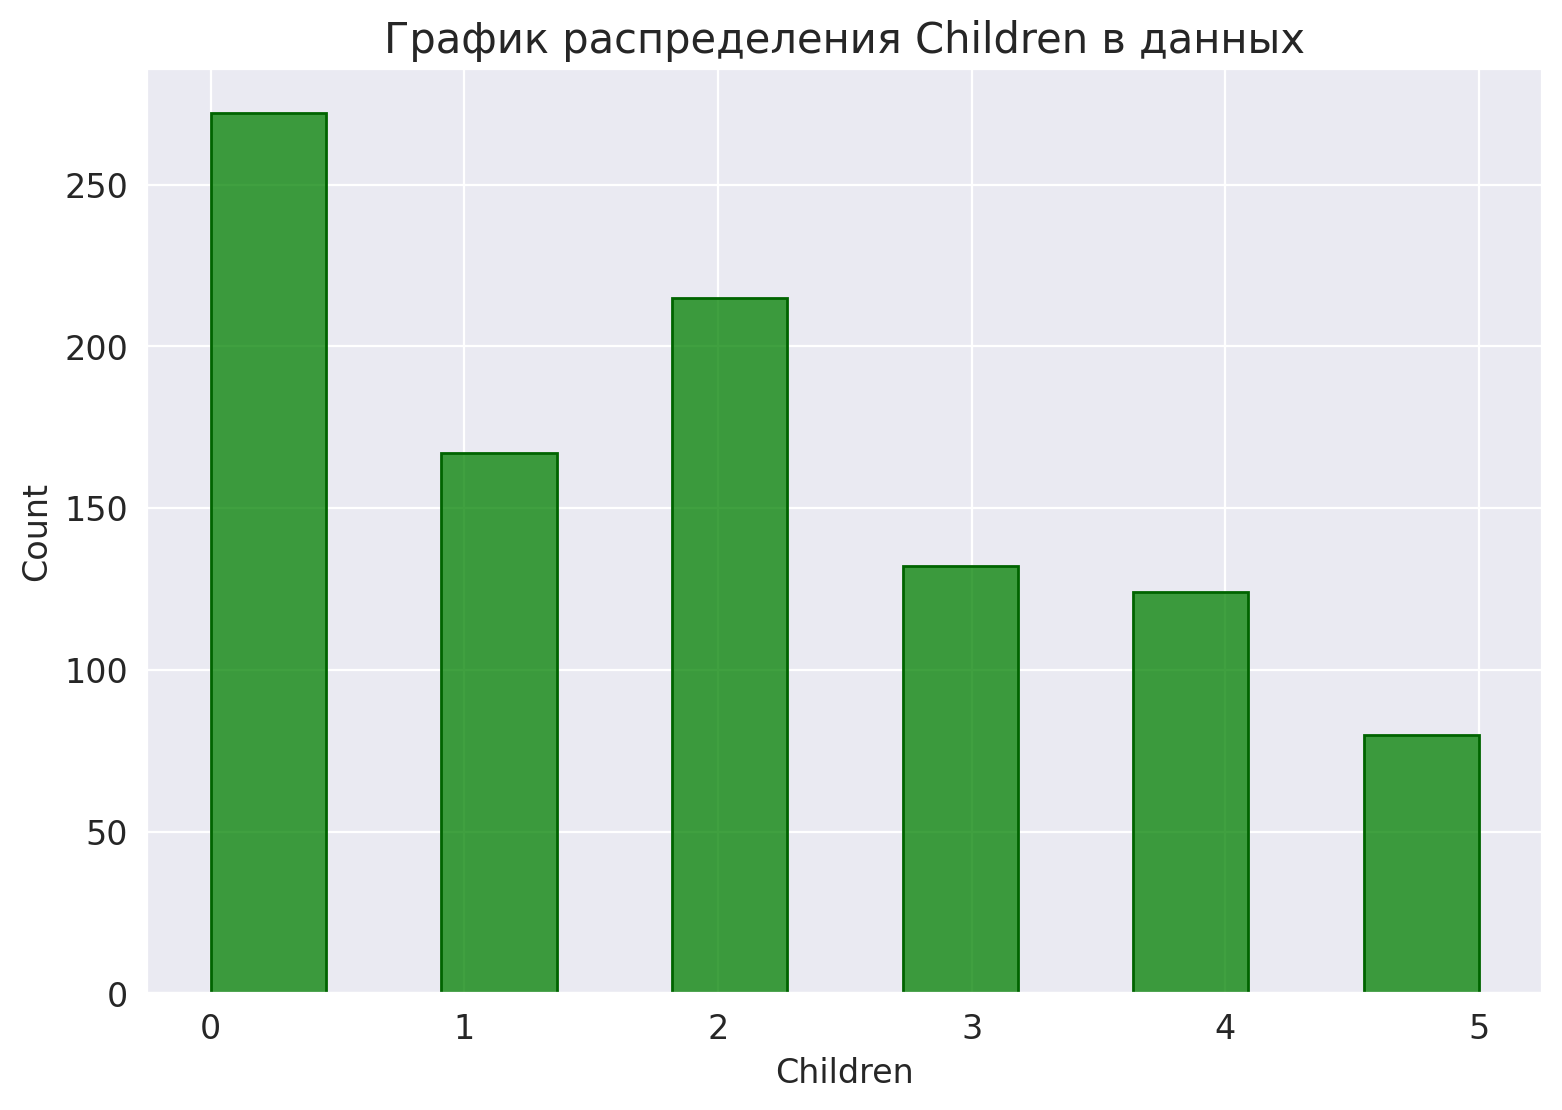

In [112]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('График распределения Children в данных', fontsize=15)
sns.histplot(X.Children,
             ax=ax,

             color='green',
             edgecolor='darkgreen')

plt.show()

Тут нет выбросов.

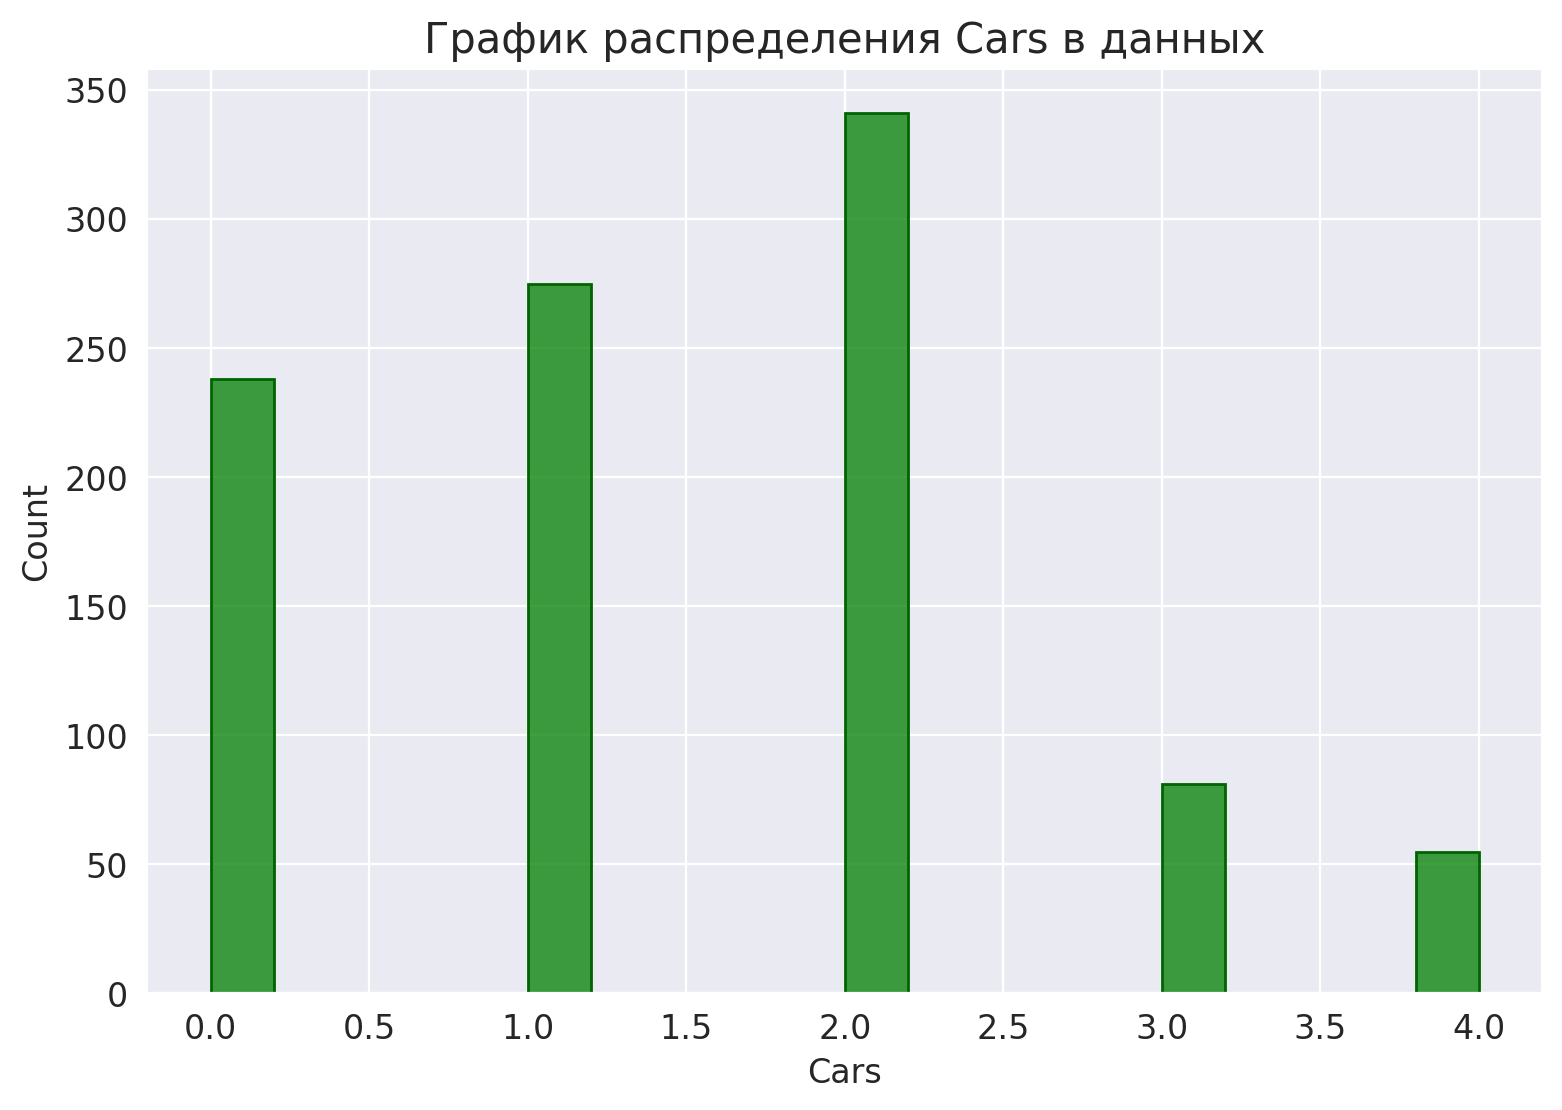

In [113]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('График распределения Cars в данных', fontsize=15)
sns.histplot(X.Cars,
             ax=ax,

             color='green',
             edgecolor='darkgreen')

plt.show()

Тут тоже нет выбросов.

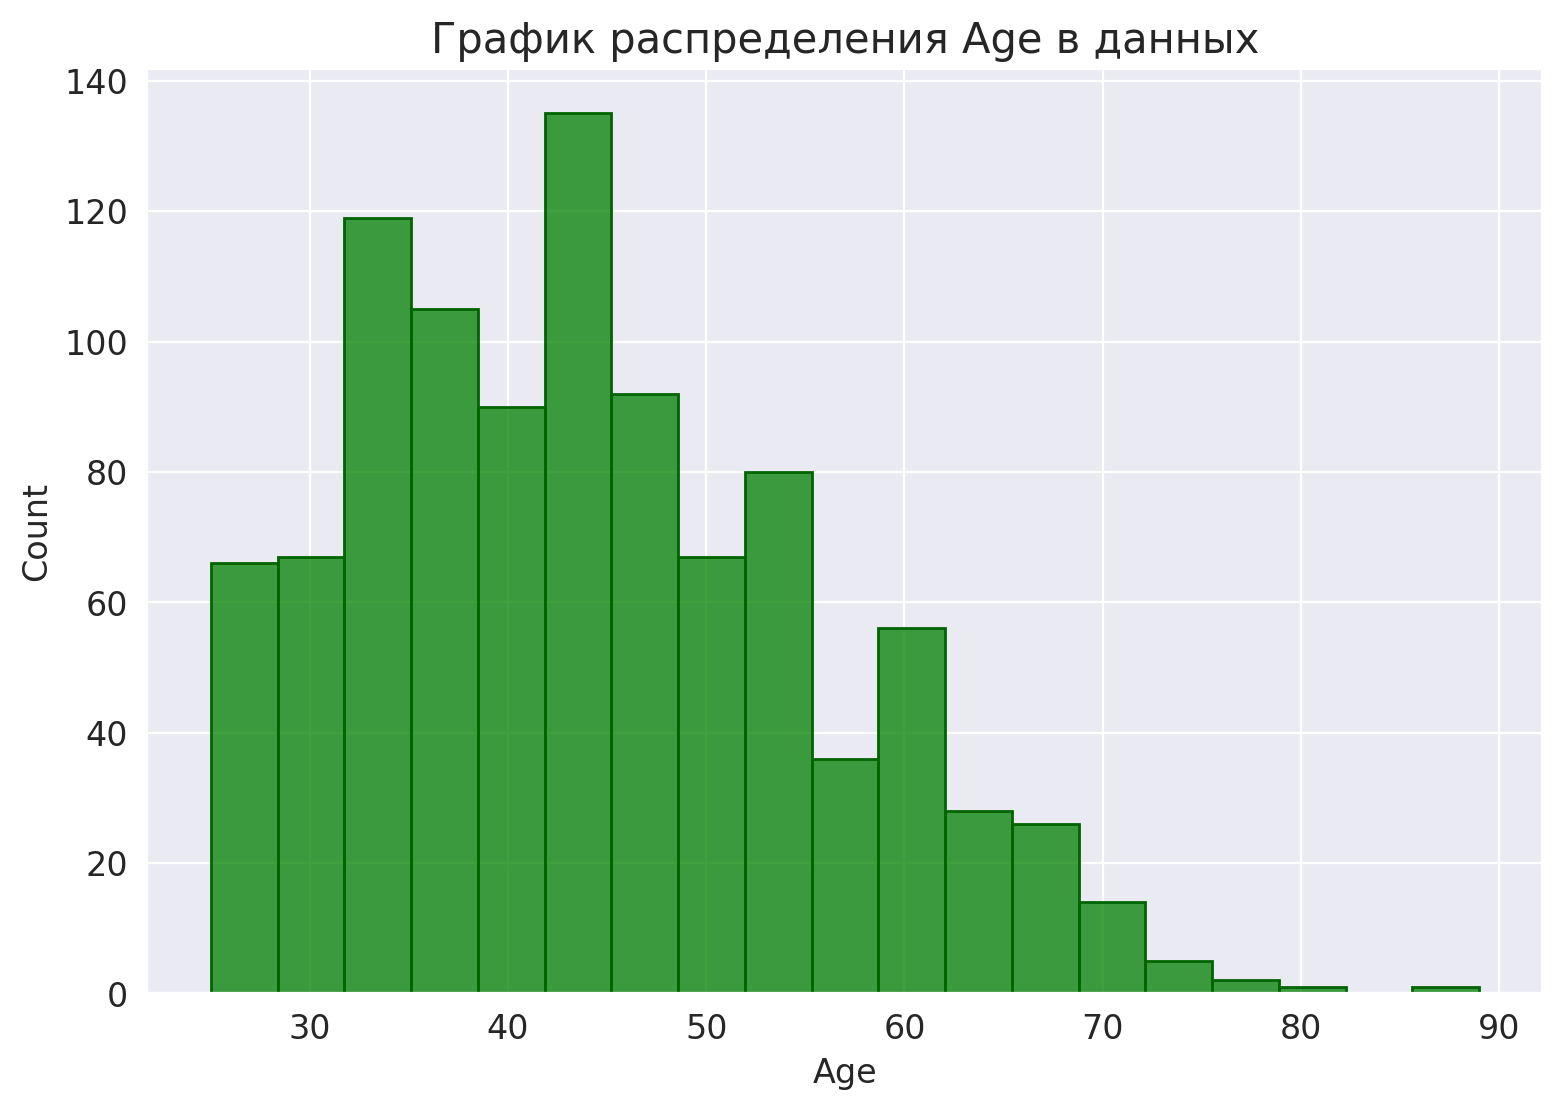

In [114]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('График распределения Age в данных', fontsize=15)
sns.histplot(X.Age,
             ax=ax,

             color='green',
             edgecolor='darkgreen')

plt.show()

In [115]:
mask = X['Age'] < np.quantile(X['Age'], 0.99)

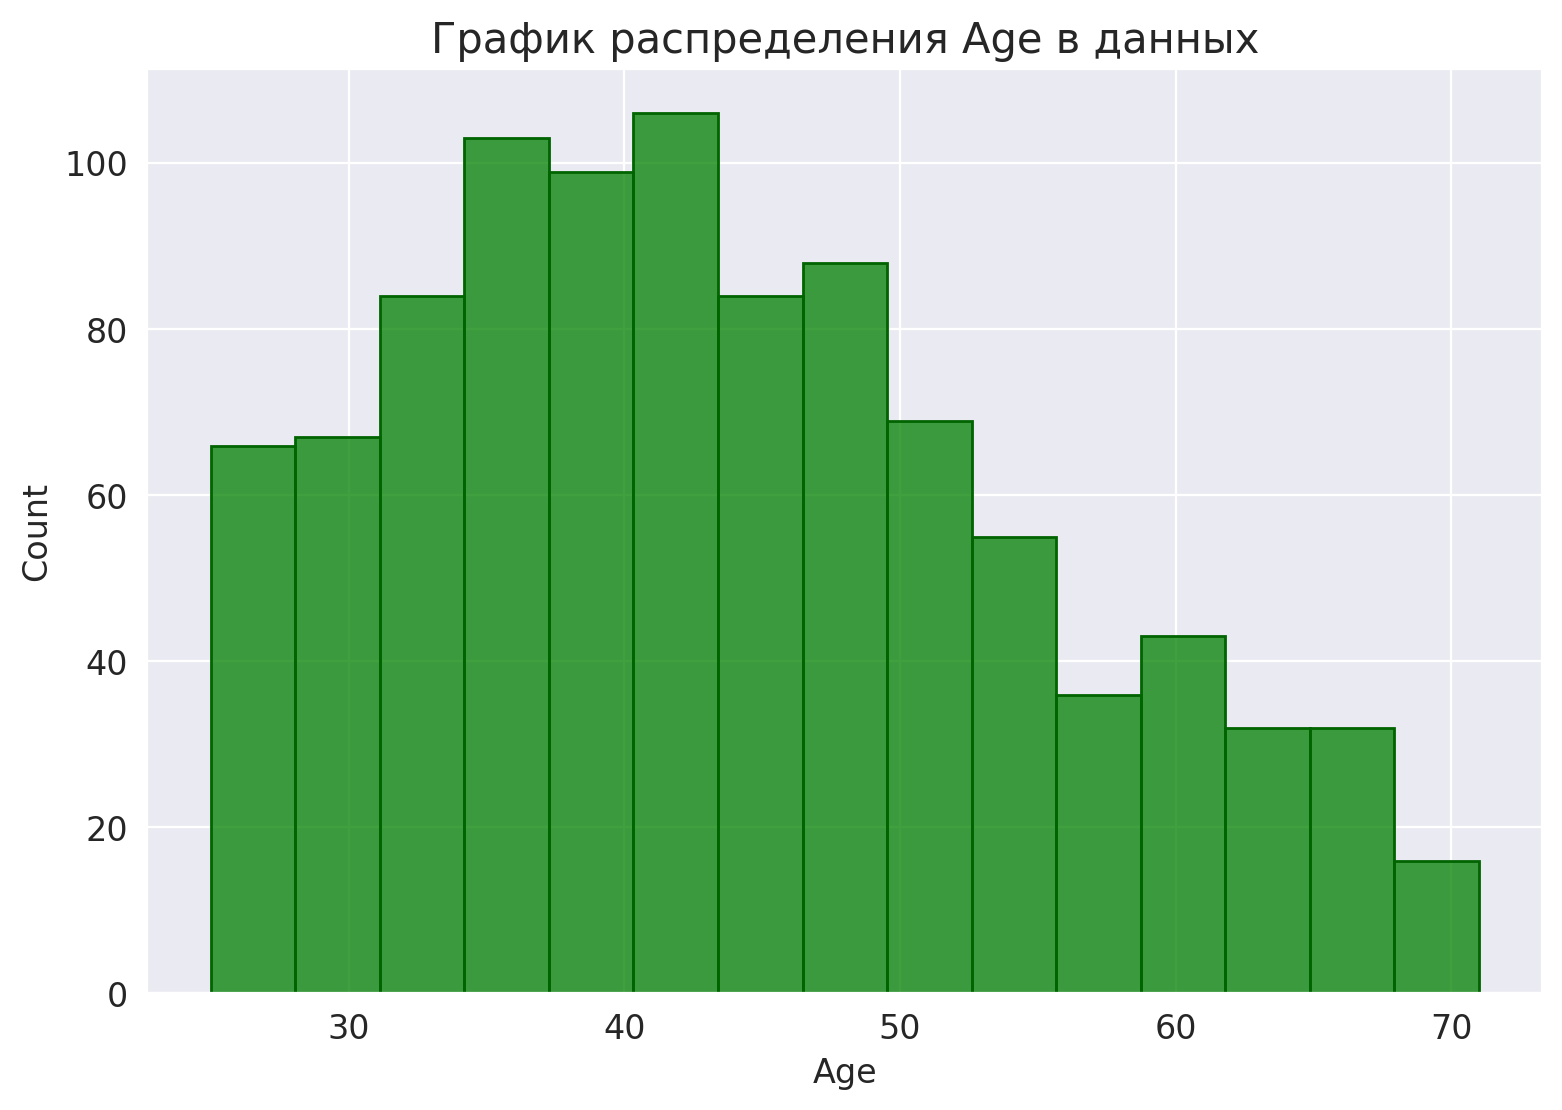

In [116]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('График распределения Age в данных', fontsize=15)
sns.histplot(X[mask].Age,
             ax=ax,

             color='green',
             edgecolor='darkgreen')

plt.show()

Избавимся от выбросов в Age (удалим 1% наибольших по Age).

In [117]:
X = X[mask]

In [118]:
y = X['Purchased Bike']

In [119]:
X_train_mte_nnum, X_test_mte_nnum, y_train, y_test = train_test_split(X[numerical + categorical], y, test_size=0.25, random_state=777, stratify=y)

noise_small = 0.01 # для больших категорий (много объектов, следовательно, нет большой потребности в шуме)
noise_big = 0.1 # для маленьких категорий (мало объектов, следовательно, высокая вероятность target leak-а, и чтобы его избежать добавляем большой)

for col in categorical:
  for val in list(X_train_mte_nnum[col].unique()):
    ser = [X_train_mte_nnum[col] == val]
    if X_train_mte_nnum[X_train_mte_nnum[col] == val].shape[0] <= 7:
      mean_target = y_train[np.array(ser).flatten()].mean() + np.random.uniform(-noise_big, noise_big)
    else:
      mean_target = y_train[np.array(ser).flatten()].mean() + np.random.uniform(-noise_small, noise_small)
    X_train_mte_nnum.loc[X_train_mte_nnum[col] == val, col] = mean_target
    X_test_mte_nnum.loc[X_test_mte_nnum[col] == val, col] = mean_target

model = LogisticRegression()
model.fit(X_train_mte_nnum, y_train)

y_pred_proba = model.predict_proba(X_test_mte_nnum)[:, 1]

print('AUC-PR на тесте:', average_precision_score(y_test, y_pred_proba))

AUC-PR на тесте: 0.6871588206304963


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [120]:
X[numerical].nunique() # серия, которая показывает количество уникальных значений у каждого признака

,0
Income,13
Children,6
Cars,5
Age,47


In [121]:
# your code here
X_train_mte_nnum, X_test_mte_nnum, y_train, y_test = train_test_split(X[numerical + categorical], y, test_size=0.25, random_state=777, stratify=y)

noise_small = 0.01 # для больших категорий (много объектов, следовательно, нет большой потребности в шуме)
noise_big = 0.1 # для маленьких категорий (мало объектов, следовательно, высокая вероятность target leak-а, и чтобы его избежать добавляем большой)

for col in X_train_mte_nnum.columns:
  for val in list(X_train_mte_nnum[col].unique()):
    ser = [X_train_mte_nnum[col] == val]
    if X_train_mte_nnum[X_train_mte_nnum[col] == val].shape[0] <= 7:
      mean_target = y_train[np.array(ser).flatten()].mean() + np.random.uniform(-noise_big, noise_big)
    else:
      mean_target = y_train[np.array(ser).flatten()].mean() + np.random.uniform(-noise_small, noise_small)
    X_train_mte_nnum.loc[X_train_mte_nnum[col] == val, col] = mean_target
    X_test_mte_nnum.loc[X_test_mte_nnum[col] == val, col] = mean_target

model = LogisticRegression()
model.fit(X_train_mte_nnum, y_train)

y_pred_proba = model.predict_proba(X_test_mte_nnum)[:, 1]

print('AUC-PR на тесте:', average_precision_score(y_test, y_pred_proba))

AUC-PR на тесте: 0.6788021967510407


Закодировав числовые признаки стало немного получше (AUC-PR немного увеличился).

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Основным плюсом является улучшение качества модели на тесте, также они не увеличивают так сильно количество признаков, следовательно, возможно, занимают меньше памяти. Минусами являются:
- большее время на кодирование признаков и обучение модели соответственно
- возможность target leak-а, которая может быть устранена шумом, сглаживанием и иными способами.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [144]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-11-28 12:57:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.1’

adult.data.1            [     <=>            ]   3.79M  3.11MB/s    in 1.2s    

2024-11-28 12:57:51 (3.11 MB/s) - ‘adult.data.1’ saved [3974305]



In [189]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
21700,47,Private,173271,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0


In [190]:
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [191]:
# your code here
X = df.drop(columns=['income'])
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [192]:
# your code here
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical)
    ], remainder='passthrough'
    )

X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

print('Количество признаков после OHE:', X_train_transformed.shape[1])
print('Количество новых признаков, которые мы получили после OHE:', X_train_transformed.shape[1] - X_train.shape[1])

Количество признаков после OHE: 108
Количество новых признаков, которые мы получили после OHE: 94


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [193]:
# your code here
model = LogisticRegression(max_iter=1000)
model.fit(X_train_transformed, y_train)

y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]
auc_pr_ohe = average_precision_score(y_test, y_pred_proba)
print('AUC-PR на тесте:', auc_pr_ohe)

AUC-PR на тесте: 0.7244182262894607


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [194]:
# your code here
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train_transformed, y_train, test_size=0.25, random_state=777, stratify=y_train)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



В чате разрешили в этом и следующем задании использовать X_train полный, без отделения валидационной выборки. Потом написали, что в этом и следующем задании надо было качество на валидационной, а я считал на тесте, не снижайте за это сильно, пожалуйста (я это поздно увидел).

In [195]:
# your code here
time_start = time.time()

weights_abs = np.abs(model.coef_.flatten())
indexes = np.argsort(-weights_abs) # отсортированный массив по убыванию
best_feat = indexes[:40]
X_train_transformed_embedded = X_train_transformed[:, best_feat]
X_test_transformed_embedded = X_test_transformed[:, best_feat]

time_end = time.time() - time_start
print('Время, потребовавшееся на отбор признаков:', time_end)

model_emb = LogisticRegression(max_iter=1000)
model_emb.fit(X_train_transformed_embedded, y_train)
y_pred_proba = model_emb.predict_proba(X_test_transformed_embedded)[:, 1]
print('AUC-PR на тесте:', average_precision_score(y_test, y_pred_proba))

Время, потребовавшееся на отбор признаков: 0.005457401275634766
AUC-PR на тесте: 0.6867478023990236


Изменилось ли качество? Как?

Да, качество изменилось в худшую сторону, AUC-PR был 0.7244182262894607, стал 0.6867478023990236.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [196]:
# your code here
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numerical)
    ], remainder='passthrough'
    )
X_train_transformed_new = column_transformer.fit_transform(X_train)
X_test_transformed_new = column_transformer.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_transformed_new, y_train)

y_pred_proba = model.predict_proba(X_test_transformed_new)[:, 1]
auc_pr_ohe_scaled = average_precision_score(y_test, y_pred_proba)
print('AUC-PR на тесте:', auc_pr_ohe_scaled)

AUC-PR на тесте: 0.7672340764944497


In [197]:
weights_abs = np.abs(model.coef_.flatten())
indexes = np.argsort(-weights_abs) # отсортированный массив по убыванию
best_feat = indexes[:40]
X_train_transformed_new_embedded = X_train_transformed_new[:, best_feat]
X_test_transformed_new_embedded = X_test_transformed_new[:, best_feat]

model_emb = LogisticRegression(max_iter=1000)
model_emb.fit(X_train_transformed_new_embedded, y_train)
y_pred_proba = model_emb.predict_proba(X_test_transformed_new_embedded)[:, 1]
print('AUC-PR на тесте:', average_precision_score(y_test, y_pred_proba))

AUC-PR на тесте: 0.7328371290051048


Качество улучшилось по сравнению с тем, когда мы не масштабировали numerical признаки перед выбором лучших 40 признаков: AUC-PR был 0.6867478023990236, а стал 0.7328371290051048. Но AUC-PR стал хуже, чем при обучении на всех 108 признаках (0.7672340764944497).

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [198]:
# your code here
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical)
    ], remainder='passthrough'
    )

X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)
scaler = StandardScaler(with_mean=False) # отмасштабируем все 108 признака
X_train_transformed_new = scaler.fit_transform(X_train_transformed)
X_test_transformed_new = scaler.transform(X_test_transformed)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_transformed_new, y_train)

y_pred_proba = model.predict_proba(X_test_transformed_new)[:, 1]
auc_pr_ohe_scaled = average_precision_score(y_test, y_pred_proba)
print('AUC-PR на тесте:', auc_pr_ohe_scaled)

AUC-PR на тесте: 0.7662604270064423


In [199]:
weights_abs = np.abs(model.coef_.flatten())
indexes = np.argsort(-weights_abs) # отсортированный массив по убыванию
best_feat_all_scal = indexes[:40]
X_train_transformed_new_embedded = X_train_transformed_new[:, best_feat_all_scal]
X_test_transformed_new_embedded = X_test_transformed_new[:, best_feat_all_scal]

model_emb = LogisticRegression(max_iter=1000)
model_emb.fit(X_train_transformed_new_embedded, y_train)
y_pred_proba = model_emb.predict_proba(X_test_transformed_new_embedded)[:, 1]
print('AUC-PR на тесте:', average_precision_score(y_test, y_pred_proba))

print('Список индексов лучших 40 признаков (без масштабирования one-hot-закодированных признаков):', best_feat)
print('Список индексов лучших 40 признаков (с масштабированием one-hot-закодированных признаков):', best_feat_all_scal)

AUC-PR на тесте: 0.7611875719047819
Список индексов лучших 40 признаков (без масштабирования one-hot-закодированных признаков): [105  26  41  27  64  29  37  50  58  52  30  66  28  36  62  70  61  49
  82  71  40 104   8  43  25  22  45  53  42   1  95  68  87 100  90  72
  84  12  65  31]
Список индексов лучших 40 признаков (с масштабированием one-hot-закодированных признаков): [105  29  22  27  58  50  25  41 107  40 102  55  99  57  20  14  47   9
  10 106  21  86  30  37  18   6  15  19  23  13  60   4  38  36   2  52
  12  64  32  31]


Да, список лучших 40 признаков изменился. Качество улучшилось: AUC-PR на 40 лучших признаках был 0.7328371290051048, стал 0.7611875719047819.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** если признак обладает высокой положительной или отрицательной корреляцией с целевой переменной, то он несет в себе много информации о целевой переменной (такие признаки будут полезны для предсказаний модели). Если корреляция между признаком и целевой переменной близка к нулю, то он неинформативен: такие признаки, скорее всего, будут бесполезны для предсказаний модели, поэтому их стоит удалить.

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [200]:
# your code here
from scipy.stats import pearsonr
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical)
    ], remainder='passthrough'
    )

X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

time_start = time.time()

correlations = []
for i in range(X_train_transformed.shape[1]):
  col = X_train_transformed[:, i].toarray().flatten()
  correlations.append(pearsonr(col, y_train)[0])

correlations = np.array(correlations)
correlations_abs = np.abs(correlations)
indexes = np.argsort(-correlations_abs) # отсортированный массив по убыванию
best_feats = indexes[:40]

X_train_transformed_new_filt = X_train_transformed[:, best_feats]
X_test_transformed_new_filt = X_test_transformed[:, best_feats]

time_end = time.time() - time_start
print('Время, потребовавшееся на отбор признаков:', time_end)

model_filt = LogisticRegression(max_iter=1000)
model_filt.fit(X_train_transformed_new_filt, y_train)
y_pred_proba = model_filt.predict_proba(X_test_transformed_new_filt)[:, 1]
print('AUC-PR на тесте:', average_precision_score(y_test, y_pred_proba))

Время, потребовавшееся на отбор признаков: 0.4184231758117676
AUC-PR на тесте: 0.7575006035696921


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [201]:
# your code here
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical)
    ], remainder='passthrough'
    )

X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

time_start = time.time()

pos_ind = np.array([y_train == 1]).flatten()
neg_ind = np.array([y_train == 0]).flatten()

t_stats = []
for i in range(X_train_transformed.shape[1]):
  col = X_train_transformed[:, i].toarray().flatten()
  pos_mu = col[pos_ind].mean()
  neg_mu = col[neg_ind].mean()
  pos_n = len(col[pos_ind])
  neg_n = len(col[neg_ind])
  pos_std = np.std(col[pos_ind], ddof=1)
  neg_std = np.std(col[neg_ind], ddof=1)
  top = np.abs(pos_mu - neg_mu)
  bottom = np.sqrt((pos_n * (pos_std ** 2) + neg_n * (neg_std ** 2)) / (pos_n + neg_n))
  t_stats.append(top / bottom)

t_stats = np.array(t_stats)

indexes = np.argsort(-t_stats_abs) # отсортированный массив по убыванию

best_features = indexes[:40]

X_train_transformed_new_filtt = X_train_transformed[:, best_features]
X_test_transformed_new_filtt = X_test_transformed[:, best_features]

time_end = time.time() - time_start
print('Время, потребовавшееся на отбор признаков:', time_end)

model_filtt = LogisticRegression(max_iter=1000)
model_filtt.fit(X_train_transformed_new_filtt, y_train)
y_pred_proba = model_filtt.predict_proba(X_test_transformed_new_filtt)[:, 1]
print('AUC-PR на тесте:', average_precision_score(y_test, y_pred_proba))

Время, потребовавшееся на отбор признаков: 0.25119781494140625
AUC-PR на тесте: 0.7575006035696921


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC-PR получился такой же, так как наборы лучших признаков совпали (см. ниже).

In [174]:
print(best_feats)
print(best_features)
print(best_feats == best_features)

[ 27  47 104  29 102  50 107 105  59  58  36  48  42  21  18  23  40 106
  51  19   5  25  20  52  55  33  10  57  38  49   4  30  32   0   9  24
  39  86   1  31]
[ 27  47 104  29 102  50 107 105  59  58  36  48  42  21  18  23  40 106
  51  19   5  25  20  52  55  33  10  57  38  49   4  30  32   0   9  24
  39  86   1  31]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

Для подбора длины шага (m) нам понадобится валидационная выборка, которая получилась после разбиения X_train на X_train1 и X_val1.

In [217]:
# your code here
сolumn_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numerical)
    ], remainder='passthrough'
    )
X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train_transformed, y_train, test_size=0.25, random_state=777, stratify=y_train)

k = 40
m_vars = [1, 2, 3, 5, 10, 15, 20] # подберем из этого набора длину шага по валидационной выборке

best_auc_pr = 0
for m in m_vars:
  while X_val1.shape[1] > k:
    model = LogisticRegression(max_iter=1000)
    model.fit(X_val1, y_val1) # будем считать бесполезными те признаки, модуль корреляции с целевой переменной которых наименьший

    weights_abs = np.abs(model.coef_.flatten())
    indexes = np.argsort(-weights_abs) # отсортированный массив по убыванию

    if X_val1.shape[1] - m >= k:
      X_val1 = X_val1[:, indexes[:-m]]
      X_test_transformed = X_test_transformed[:, indexes[:-m]]
    else:
      m_new = X_val1.shape[1] - k
      X_val1 = X_val1[:, indexes[:-m_new]]
      X_test_transformed = X_test_transformed[:, indexes[:-m_new]]


  model = LogisticRegression(max_iter=1000)
  model.fit(X_val1, y_val1)
  y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]
  if average_precision_score(y_test, y_pred_proba) > best_auc_pr:
    m_best = m
    best_auc_pr = average_precision_score(y_test, y_pred_proba)

print('Best AUC-PR:', best_auc_pr)
print('Best learning rate:', m_best)

Best AUC-PR: 0.7385217154719451
Best learning rate: 1


In [218]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numerical)
    ], remainder='passthrough'
    )
X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train_transformed, y_train, test_size=0.25, random_state=777, stratify=y_train)

k = 40
m = m_best

time_start = time.time()

while X_train1.shape[1] > k:
  model = LogisticRegression(max_iter=1000)
  model.fit(X_train1, y_train1) # будем считать бесполезными те признаки, модуль весов для которых наименьший

  weights_abs = np.abs(model.coef_.flatten())
  indexes = np.argsort(-weights_abs) # отсортированный массив по убыванию

  if X_train1.shape[1] - m >= k:
    X_train1 = X_train1[:, indexes[:-m]]
    X_test_transformed = X_test_transformed[:, indexes[:-m]]
  else:
    m_new = X_train1.shape[1] - k
    X_train1 = X_train1[:, indexes[:-m_new]]
    X_test_transformed = X_test_transformed[:, indexes[:-m_new]]

time_end = time.time() - time_start
print('Время, потребовавшееся на отбор признаков:', time_end)

model = LogisticRegression(max_iter=1000)
model.fit(X_train1, y_train1)
y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]
print('AUC-PR на тесте:', average_precision_score(y_test, y_pred_proba))

Время, потребовавшееся на отбор признаков: 14.834283113479614
AUC-PR на тесте: 0.7343896177732919


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

Думал над этим заданием очень долго, устал, забил в чат гпт промпт было такое задание "задание на метод-обертки, когда убирали признаки, чтобы осталось 40" и вот такое решение "код, который я написал для ответа на задание выше (только без первой части с подбором длины шага, строку с m изменил на 'm = 5')" переделай код в соответствии с этим заданием "текст задания сверху". Вот, что он выдал:

In [228]:
# Подготовка данных
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numerical)
], remainder='passthrough')

X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

# Разделение данных
X_train1, X_val1, y_train1, y_val1 = train_test_split(
    X_train_transformed, y_train, test_size=0.25, random_state=777, stratify=y_train
)

# Параметры
k = 40  # количество признаков, которые нужно выбрать
m = 5   # число признаков, добавляемых на каждом шаге
selected_features = []  # индексы выбранных признаков
remaining_features = list(range(X_train1.shape[1]))  # индексы оставшихся признаков

time_start = time.time()
best_auc_pr = 0  # лучшее качество модели на текущий момент
quality_deteriorated = False  # флаг ухудшения качества

while len(selected_features) < k and not quality_deteriorated:
    # Если добавляем по m признаков, ограничим количество
    num_to_add = min(m, k - len(selected_features))

    # Оценка значимости признаков на текущем шаге
    model = LogisticRegression(max_iter=1000, random_state=777)
    model.fit(X_train1[:, selected_features + remaining_features], y_train1)

    # Оценка важности признаков: модули весов
    weights_abs = np.abs(model.coef_.flatten())
    remaining_weights = weights_abs[len(selected_features):]  # важности только для оставшихся признаков
    important_indices = np.argsort(-remaining_weights)[:num_to_add]  # выбираем наиболее значимые

    # Переносим выбранные признаки из remaining_features в selected_features
    for idx in important_indices:
        selected_features.append(remaining_features[idx])
    remaining_features = [remaining_features[i] for i in range(len(remaining_features)) if i not in important_indices]

    # Оценка качества модели на валидационной выборке
    model.fit(X_train1[:, selected_features], y_train1)
    y_val_pred_proba = model.predict_proba(X_val1[:, selected_features])[:, 1]
    auc_pr = average_precision_score(y_val1, y_val_pred_proba)

    print(f"Добавлено признаков: {len(selected_features)}, AUC-PR: {auc_pr:.4f}")

    # Проверяем, не ухудшилось ли качество
    if auc_pr < best_auc_pr:
        quality_deteriorated = True
    else:
        best_auc_pr = auc_pr

time_end = time.time() - time_start
print('Время, потребовавшееся на отбор признаков:', time_end)

# Финальная модель на тесте
final_model = LogisticRegression(max_iter=1000, random_state=777)
final_model.fit(X_train1[:, selected_features], y_train1)
y_test_pred_proba = final_model.predict_proba(X_test_transformed[:, selected_features])[:, 1]
test_auc_pr = average_precision_score(y_test, y_test_pred_proba)

print(f'AUC-PR на тесте: {test_auc_pr:.4f}')
print(f'Итоговое количество выбранных признаков: {len(selected_features)}')

Добавлено признаков: 5, AUC-PR: 0.5393
Добавлено признаков: 10, AUC-PR: 0.5701
Добавлено признаков: 15, AUC-PR: 0.6233
Добавлено признаков: 20, AUC-PR: 0.7207
Добавлено признаков: 25, AUC-PR: 0.7227
Добавлено признаков: 30, AUC-PR: 0.7233
Добавлено признаков: 35, AUC-PR: 0.7245
Добавлено признаков: 40, AUC-PR: 0.7310
Время, потребовавшееся на отбор признаков: 1.7985875606536865
AUC-PR на тесте: 0.7312
Итоговое количество выбранных признаков: 40


Как я понимаю, это все равно немного не то, так как он все время обучает модель, из которой мы берем веса для оценки важности признаков, на всех признаках (и selected, и remaining), поэтому как будто нет разницы от того, берем мы по 5 штук наилучших каждую итерацию цикла или все 40 сразу.

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** на 40 оставшихся признаках наилучшее качество показал встроенный метод с отмасштабированными всеми 108 признаками до выбора лучших 40.

встроенный метод: плюс - быстрый и относительно несложный

метод фильтрации данных: плюс - самый простой в реализации, минус - качество похуже

метод-обертка: минус - требует много времени, дает качество похуже остальных

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [ ]:
df.head()

In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [ ]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        # your code here

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            # "metric_key": metric_value
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [ ]:
# your code here

Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [ ]:
# your code here

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [ ]:
# your code here

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [ ]:
# your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
# your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [ ]:
# your code here

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




In [ ]:
# your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ # your answer here

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [ ]:
# your code here

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ я съел несколько кусков сыра, макароны с куриными котлетами и шоколадный творожный сырок.